<h1> Sentiment analysis</h1>
Task: analyze the results of different tools for sentiment analysis<br><br>
<strong>Here are the papers I used:</strong><br>
    <p style="padding-left:5em">KZhang, Xiang, Junbo Zhao, and Yann LeCun. "Character-level convolutional networks for text 
classification." Advances in neural information processing systems 28 (2015).</p>
    <p style="padding-left:5em">Gatti, L., Guerini, M., & Turchi, M. (2015). SentiWords: Deriving a high precision and high 
coverage lexicon for sentiment analysis. IEEE Transactions on Affective Computing, 7(4), 409-
421.
</p>

<h2>Yelp dataset</h2>
    The dataset contains 1000 entries with two columns -> text, weight  <br>
    <hr>
    <p style="background-color: rgb(255, 127, 0);color:black;font-weight:bold">Text column consist of strings representing different comments  <span style="position:absolute;right:10em">string</span> <br></p>
    <p style="background-color: rgb(0, 255, 127);color:black;font-weight:bold">Weight collumn consist of two classes 0 for 1-2 stars and 1 for 3-4 stars,<br> where 0 mean Text is neative and 1 means Text is positive<span style="position:absolute;right:10em">number</span> <br></p>

<h2>Add libraries</h2>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, f1_score)
import re
import stanza
from tqdm import tqdm

In [2]:
yelp_data = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_data.columns = ['Text', 'Weight']
yelp_data.head()

,Text,Weight
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<h2>Process SentiWords data</h2>

In [3]:
senti_words = []

with open('SentiWords_1.1.txt') as f:
    lines = f.readlines()

for line in lines:
    if(line[0] != '#'):
        line = line.replace('\n', "")
        senti_words.append(line)
senti_words = [re.split('#|\t', row) for row in senti_words]
senti_words = pd.DataFrame(senti_words, columns =['Lemma', "PoS", "Priority"])
senti_words["Priority"] = senti_words["Priority"].astype(float)
senti_words.head()

,Lemma,PoS,Priority
0,.22_caliber,a,0.00000
1,.22_calibre,a,0.00000
2,.22-caliber,a,0.00000
3,.22-calibre,a,0.00000
4,.22,n,0.12208


<h2>Explanaition</h2>

<p>I have read the txt file, then I pushed the elements that started with any other character than "#"</p>
<p>Then I have used replace method to replace new line separators with empty string, and appended everything into array</p>
<p>In my next step, I have used regex split to separate each element of array into array of three elements</p>
<p>As ultimate step I have converted the list into dataframe with lemma, pos, priority columns</p>
<p>Finally I changed the type of priority to be a float column</p>

<h2>Create my classifier</h2>

In [27]:
class myClassifier():

    def __init__(self):
        self.stanzaSupp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma', download_method='reuse_resources')
        self.myDict = senti_words.set_index(['Lemma', 'PoS'])['Priority'].to_dict()

    def stanzaToSenti(self, tag):
        if tag == 'ADJ':
            return 'a'
        if tag == 'VERB':
            return 'v'
        if tag == 'ADV':
            return 'r'
        return 'n'
    
    def sentiScore(self,lemma, pos):
        if (lemma, pos) in self.myDict:
            return self.myDict[(lemma, pos)]
        return 0
        
    def predict(self, doc):                
        doc = self.stanzaSupp(doc)
        total_score = 0
        for sentence in doc.sentences:
            for word in sentence.words:
                lemma = word.lemma
                pos = self.stanzaToSenti(word.pos)  
                total_score += self.sentiScore(lemma, pos)
        return 1 if total_score>=0 else 0


In [28]:
first_model = myClassifier()

2023-09-21 21:35:21 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2023-09-21 21:35:21 INFO: Using device: cpu
2023-09-21 21:35:21 INFO: Loading: tokenize
2023-09-21 21:35:21 INFO: Loading: pos
2023-09-21 21:35:21 INFO: Loading: lemma
2023-09-21 21:35:21 INFO: Done loading processors!


<h2>Evaluate model</h2>

In [29]:
predictions = []
for ix in yelp_data.index:
    res = first_model.predict(yelp_data['Text'][ix])
    predictions.append(res)

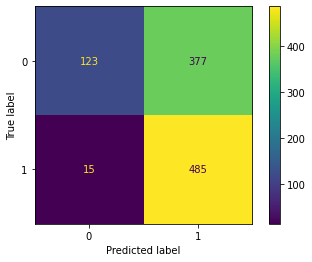

F1 score for positive class: 0.7122
F1 score for negative class: 0.3856


In [31]:
labels = yelp_data['Weight'].values

disp = ConfusionMatrixDisplay(confusion_matrix(labels, predictions))
disp.plot()
plt.show()

print(f'F1 score for positive class: {f1_score(labels, predictions, pos_label=1):.4}')
print(f'F1 score for negative class: {f1_score(labels, predictions, pos_label=0):.4}')

<h2>Stanza sentiment analysis</h2>

In [11]:
stanza_model = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

2023-09-21 21:24:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-21 21:24:13 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2023-09-21 21:24:13 INFO: Using device: cpu
2023-09-21 21:24:13 INFO: Loading: tokenize
2023-09-21 21:24:13 INFO: Loading: sentiment
2023-09-21 21:24:13 INFO: Done loading processors!


In [25]:
stanza_predictions = []

for i, row in tqdm(yelp_data.iterrows(), total=len(yelp_data)):
    doc = stanza_model(row['Text'])
    sentence = doc.sentences[0]
    stanza_predictions.append(max(0, sentence.sentiment-sentence.sentiment**0))
    
# stanza_predictions = np.array(stanza_predictions)

100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s]


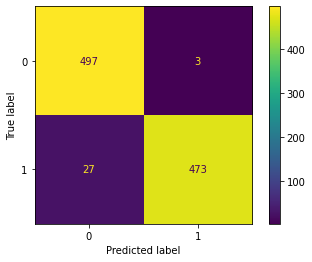

F1 score for positive class: 0.9693
F1 score for negative class: 0.9707


In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels, stanza_predictions))
disp.plot()
plt.show()

print(f'F1 score for positive class: {f1_score(labels, stanza_predictions, pos_label=1):.4}')
print(f'F1 score for negative class: {f1_score(labels, stanza_predictions, pos_label=0):.4}')

<h2>Conclusion</h2>

<p>My classifier performs really bad due to misclassification of negative weights as positive weights. The reason I bilieve is the words that were not present in sentiWordDataset. <br>
    On the other hand stanza have showed a really impressive accuracy for detecting the sentiments of sentences.</p>